# Introduction to Retinal Transformation and Visual Pathways

In this notebook, we delve into a state-of-the-art retinal transformation approach, an integral part of our research detailed in the paper _"A Dual-Stream Neural Network Explains the Functional Segregation of Dorsal and Ventral Visual Pathways in Human Brains"_[1]. Our methodology and code are inspired by groundbreaking research conducted by Bashivan, Kar, and DiCarlo (2019)[2], who demonstrated the potential of using deep image synthesis for neural population control.

## Conceptual Foundation and Technical Acknowledgment

The concept of replicating retinal information processing, akin to the human visual system's capability, draws upon the seminal work of Bashivan et al., who utilized deep image synthesis techniques to manipulate neural activity patterns in the visual cortex. Their insights into the neural underpinnings of vision have been instrumental in shaping the computational aspects of our retinal transformation model.

## Leveraging Deep Image Synthesis for Retinal Modeling

Following the lead of Bashivan et al., we apply a similar deep image synthesis framework to model how visual information might be sampled and represented in the retina. This allows us to approximate the non-linear and fixation-dependent features of retinal sampling, providing a window into how such processes could be abstracted and implemented in artificial neural networks.

## The Dual-Stream Hypothesis and Visual Information Processing

Our investigation contributes to a deeper understanding of the dual-stream hypothesis, which proposes two parallel pathways in the visual cortex, each with its unique functional attributes. The research by Bashivan et al. lays the groundwork for considering how neural networks can be engineered to emulate these pathways, providing a computational perspective on the distinction between the dorsal and ventral streams.

## Structure of This Notebook

We begin by defining the necessary functions and preparing our datasets. Each step is documented and executed to demonstrate the process of retinal transformation, visualization, and analysis. In adhering to academic integrity and the collaborative spirit of scientific research, we credit the foundational ideas and methods to the work of Bashivan et al. Their innovative approach to neural population control via deep image synthesis has been pivotal in informing our models and experiments.

```python
# Reference
[1] Choi, Minkyu, et al. A Dual-Stream Neural Network Explains the Functional Segregation of Dorsal and Ventral Visual Pathways in Human Brains. arXiv preprint arXiv:2310.13849 (2023).
[2] Bashivan, P., Kar, K., & DiCarlo, J. J. (2019). Neural population control via deep image synthesis. Science, 364(6439), eaav9436.


In [1]:
# Importing necessary libraries for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Importing libraries for image processing and visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt

# This is specific to using OpenCV within Google Colab environments
# which allows displaying images directly in the notebook
from google.colab.patches import cv2_imshow

from typing import Tuple


--2023-12-05 19:29:29--  https://github.com/minkyu-choi04/Perceptual_Losses_for_Real_Time_Style_Transfer/raw/master/content.jpg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/minkyu-choi04/Perceptual_Losses_for_Real_Time_Style_Transfer/master/content.jpg [following]
--2023-12-05 19:29:29--  https://raw.githubusercontent.com/minkyu-choi04/Perceptual_Losses_for_Real_Time_Style_Transfer/master/content.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144300 (141K) [image/jpeg]
Saving to: ‘scene.jpg’

scene.jpg           100%[===================>] 140.92K  --.-KB/s    in 0.09s   

2023-12-05 19

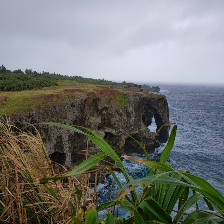

tensor(0.9451) tensor(0.)


In [2]:
# Cell to fetch and prepare an image for model input

# Downloading an example image using wget command
!wget https://github.com/minkyu-choi04/Perceptual_Losses_for_Real_Time_Style_Transfer/raw/master/content.jpg -O scene.jpg

# Read the image using OpenCV
img_o = cv2.imread('scene.jpg')

# Resize the image to 224x224 which is typically required for CNNs input
img_o = cv2.resize(img_o, (224, 224), interpolation=cv2.INTER_CUBIC)

# Display the image in the notebook using the cv2_imshow function from Google Colab
cv2_imshow(img_o)

# Convert the image to a PyTorch tensor for model consumption
img_t = torch.tensor(img_o)

# Permute the image dimensions to have the channel dimension first (as expected by PyTorch models)
img_t = img_t.permute(2, 0, 1)

# Add a batch dimension since models expect a batch of images, not a single image
img_t = img_t.unsqueeze(0)

# Convert the image tensor to floating point and normalize it to have values between 0 and 1
img_t = img_t.to(torch.float32)
img_t = img_t / 255.0

# Print out the maximum and minimum values to ensure it's normalized
print(torch.max(img_t), torch.min(img_t))


# Define Functions

In [3]:
def convert_xy2ret(xy: torch.Tensor, a: float, b: float, m: int, n: int) -> torch.Tensor:
    """
    Convert x or y to retinal coordinates.

    Args:
        xy (torch.Tensor): Grid coordinates of either x or y (shape: (b, 1)).
        a (float): Parameter a as per the referenced paper.
        b (float): Parameter b as per the referenced paper.
        m (int): Resolution of the full image.
        n (int): Resolution of the sampled image.

    Returns:
        torch.Tensor: Transformed coordinates corresponding to retinal coordinates.
    """
    xy_ret = 2 / a * torch.log(1 - np.sqrt(np.pi) / b * (1 - np.exp(a / 2)) * xy)
    return xy_ret

def convert_ret2xy(xy_ret: torch.Tensor, a: float, b: float, m: int, n: int) -> torch.Tensor:
    """
    Convert retinal coordinates to x or y coordinates.

    Args:
        xy_ret (torch.Tensor): Retinal grid coordinates (shape: (b, 1)).
        a (float): Parameter a as per the referenced paper.
        b (float): Parameter b as per the referenced paper.
        m (int): Resolution of the full image.
        n (int): Resolution of the sampled image.

    Returns:
        torch.Tensor: Transformed coordinates corresponding to x or y.
    """
    xy = b / np.sqrt(np.pi) * ((1 - torch.exp(a / 2 * xy_ret)) / (1 - np.exp(a / 2)))
    return xy

def make_regular_grid(
    range_x: Tuple[float, float] = (-1, 1),
    range_y: Tuple[float, float] = (-1, 1),
    res_xy: Tuple[int, int] = (64, 64),
    device: str = 'cuda'
  ) -> torch.Tensor:
    """
    Make a regular grid.

    Args:
        range_x (Tuple[float, float]): Range of x values for the grid.
        range_y (Tuple[float, float]): Range of y values for the grid.
        res_xy (Tuple[int, int]): Resolution of the grid.
        device (str): The device to create the grid on.

    Returns:
        torch.Tensor: Regularly spaced grid.
    """
    xxrange = torch.linspace(range_x[0], range_x[1], res_xy[0], device=device)
    yyrange = torch.linspace(range_y[0], range_y[1], res_xy[1], device=device)
    ys, xs = torch.meshgrid(yyrange, xxrange, indexing='ij')
    grid_reg = torch.stack([xs, ys], dim=-1).unsqueeze(0)
    return grid_reg


def convert_xy2rt(xy: torch.Tensor) -> torch.Tensor:
    """
    Convert xy coordinates to polar coordinates (r, theta).

    Args:
        xy (torch.Tensor): Tensor containing xy coordinates with shape (b, 2).

    Returns:
        torch.Tensor: Tensor containing polar coordinates with shape (b, 2).
    """
    rs = torch.sqrt(xy[:, 0]**2 + xy[:, 1]**2)
    ts = torch.atan2(xy[:, 1], xy[:, 0])
    rt = torch.stack([rs, ts], dim=1)
    return rt

def convert_rt2xy(rt: torch.Tensor) -> torch.Tensor:
    """
    Convert polar coordinates (r, theta) to xy coordinates.

    Args:
        rt (torch.Tensor): Tensor containing polar coordinates with shape (b, 2).

    Returns:
        torch.Tensor: Tensor containing xy coordinates with shape (b, 2).
    """
    rs = rt[:, 0]
    ts = rt[:, 1]
    xs = rs * torch.cos(ts)
    ys = rs * torch.sin(ts)
    xy = torch.stack([xs, ys], dim=1)
    return xy

def make_xy2ret_grid_r(fixs_xy: torch.Tensor, m: int, n: int, density_ratio: float) -> torch.Tensor:
    """
    Make an xy to retinal coordinates grid.

    Args:
        fixs_xy (torch.Tensor): Tensor containing fixation points with shape (b, 2).
        m (int): Size of the input image.
        n (int): Size of the output image.
        density_ratio (float): Relative density of the field of view to the periphery.

    Returns:
        torch.Tensor: The grid in xy coordinates.
    """
    output_size = (n, n)
    batch_s = fixs_xy.size(0)

    rp_max = n / m
    r_max = 1
    a = np.log(density_ratio) / rp_max
    b = np.sqrt(np.pi) * r_max * (1 - np.exp(a/2)) / (1 - np.exp(a / 2 * rp_max))

    fixs_xy_length = 1 - torch.abs(fixs_xy)

    fixs_xp = torch.sign(fixs_xy[:, 0]) * (n/m - convert_xy2ret(fixs_xy_length[:, 0], a, b, m, n))
    fixs_yp = torch.sign(fixs_xy[:, 1]) * (n/m - convert_xy2ret(fixs_xy_length[:, 1], a, b, m, n))
    fixs_xyp = torch.cat((fixs_xp.unsqueeze(1), fixs_yp.unsqueeze(1)), dim=1)

    grid_lp_xyp_reg = make_regular_grid(range_x=(-1, 1), range_y=(-1, 1), res_xy=output_size[::-1], device=fixs_xy.device)
    grid_lp_xyp_reg = grid_lp_xyp_reg * (n / m)
    grid_lp_xyp_reg = grid_lp_xyp_reg.repeat(batch_s, 1, 1, 1)
    grid_lp_xyp_reg = grid_lp_xyp_reg - fixs_xyp.unsqueeze(1).unsqueeze(1)

    grid_rtp = convert_xy2rt(grid_lp_xyp_reg.view(-1, 2))
    grid_r = convert_ret2xy(grid_rtp.view(-1, 2)[:, 0], a, b, m, n)
    grid_rt = torch.cat((grid_r.unsqueeze(1), grid_rtp.view(-1, 2)[:, 1].unsqueeze(1)), dim=1)
    grid_xy = convert_rt2xy(grid_rt).view(batch_s, *output_size, 2)
    grid_xy = grid_xy + fixs_xy.unsqueeze(1).unsqueeze(1)

    return grid_xy.view(grid_lp_xyp_reg.size())

def make_ret2xy_grid_r(fixs_xy: torch.Tensor, m: int, n: int, density_ratio: float) -> torch.Tensor:
    """
    Generates a grid for converting image from retinal space to cartesian space.

    Args:
        fixs_xy (torch.Tensor): Tensor of fixation points with shape (b, 2).
        m (int): Size of the input image.
        n (int): Size of the output image.
        density_ratio (float): Relative density of the field of view to the periphery.

    Returns:
        torch.Tensor: The grid in retinal space.
    """
    output_size = (n, n)
    batch_s = fixs_xy.size(0)

    rp_max = n / m
    r_max = 1

    a = np.log(density_ratio) / rp_max
    b = np.sqrt(np.pi) * r_max * (1 - np.exp(a/2)) / (1 - np.exp(a / 2 * rp_max))

    fixs_xy_length = 1 - torch.abs(fixs_xy)
    fixs_xp = torch.sign(fixs_xy[:, 0]) * (n/m - convert_xy2ret(fixs_xy_length[:, 0], a, b, m, n))
    fixs_yp = torch.sign(fixs_xy[:, 1]) * (n/m - convert_xy2ret(fixs_xy_length[:, 1], a, b, m, n))
    fixs_xyp = torch.cat((fixs_xp.unsqueeze(1), fixs_yp.unsqueeze(1)), dim=1)

    grid_lp_xy_reg = make_regular_grid(res_xy=output_size[::-1], device=fixs_xy.device)
    grid_lp_xy_reg = grid_lp_xy_reg.repeat(batch_s, 1, 1, 1)
    grid_lp_xy_reg = grid_lp_xy_reg - fixs_xy.unsqueeze(1).unsqueeze(1)

    grid_rt = convert_xy2rt(grid_lp_xy_reg.view(-1, 2))
    grid_rp = convert_xy2ret(grid_rt[:, 0], a, b, m, n)
    grid_rtp = torch.cat((grid_rp.unsqueeze(1), grid_rt[:, 1].unsqueeze(1)), dim=1)
    grid_xyp = convert_rt2xy(grid_rtp).view(batch_s, *output_size, 2)
    grid_xyp = grid_xyp + fixs_xyp.unsqueeze(1).unsqueeze(1)
    grid_xyp = grid_xyp / (n / m)

    return grid_xyp.view(grid_lp_xy_reg.size())


def mark_point(imgs: torch.Tensor, fixs: torch.Tensor, ds: int = 7, is_red: bool = True) -> torch.Tensor:
    """
    Marks a point on a given batch of images.

    Args:
        imgs (torch.Tensor): A batch of images with shape (b, 3, h, w) and any range.
        fixs (torch.Tensor): A batch of fixation points with shape (b, 2) and values in the range -1 to 1.
        ds (int): Size of the marked square around the fixation point.
        is_red (bool): If True, marks with red color; otherwise, marks with blue.

    Returns:
        torch.Tensor: The batch of images with marked points.
    """
    # Convert fixation points to the image scale (0 to h-1 and w-1)
    fixs = ((fixs + 1) / 2.0) * torch.tensor([imgs.shape[3], imgs.shape[2]], dtype=torch.int32, device=imgs.device)
    fixs = fixs.to(torch.int)

    # Mark the points in the images
    for b in range(imgs.shape[0]):
        # Define color channels (red or blue)
        color_channel = 0 if is_red else 2

        # Ensure the marked square does not go out of image bounds
        y_min = max(fixs[b, 1] - ds, 0)
        y_max = min(fixs[b, 1] + ds, imgs.shape[2])
        x_min = max(fixs[b, 0] - ds, 0)
        x_max = min(fixs[b, 0] + ds, imgs.shape[3])

        # Clear the square area in all channels
        imgs[b, :, y_min:y_max, x_min:x_max] = 0.0

        # Set the specified color channel to a high value (assuming max value is 2.0 for the image)
        imgs[b, color_channel, y_min:y_max, x_min:x_max] = 2.0

    return imgs


## Perform Transformations



In [4]:
# Define Batched Images and Fixations
img_b = torch.cat((img_t, img_t), 0).cuda()
fixs_xy = torch.tensor([[-0.5, 0.], [0.5, 0.5]]).cuda()

In [5]:
# Define Transformation parameters
density_ratio = 15
m = 224
n = 112

# Perform Transformation
grid_forward = make_xy2ret_grid_r(fixs_xy, m,n, density_ratio)
actmap_warp2 = torch.nn.functional.grid_sample(img_b, grid_forward, align_corners=True, mode='bilinear')

# Mark Fixations Points
img_b_point = mark_point(img_b.clone(), fixs_xy, ds=7, is_red=False)


# Plot Results

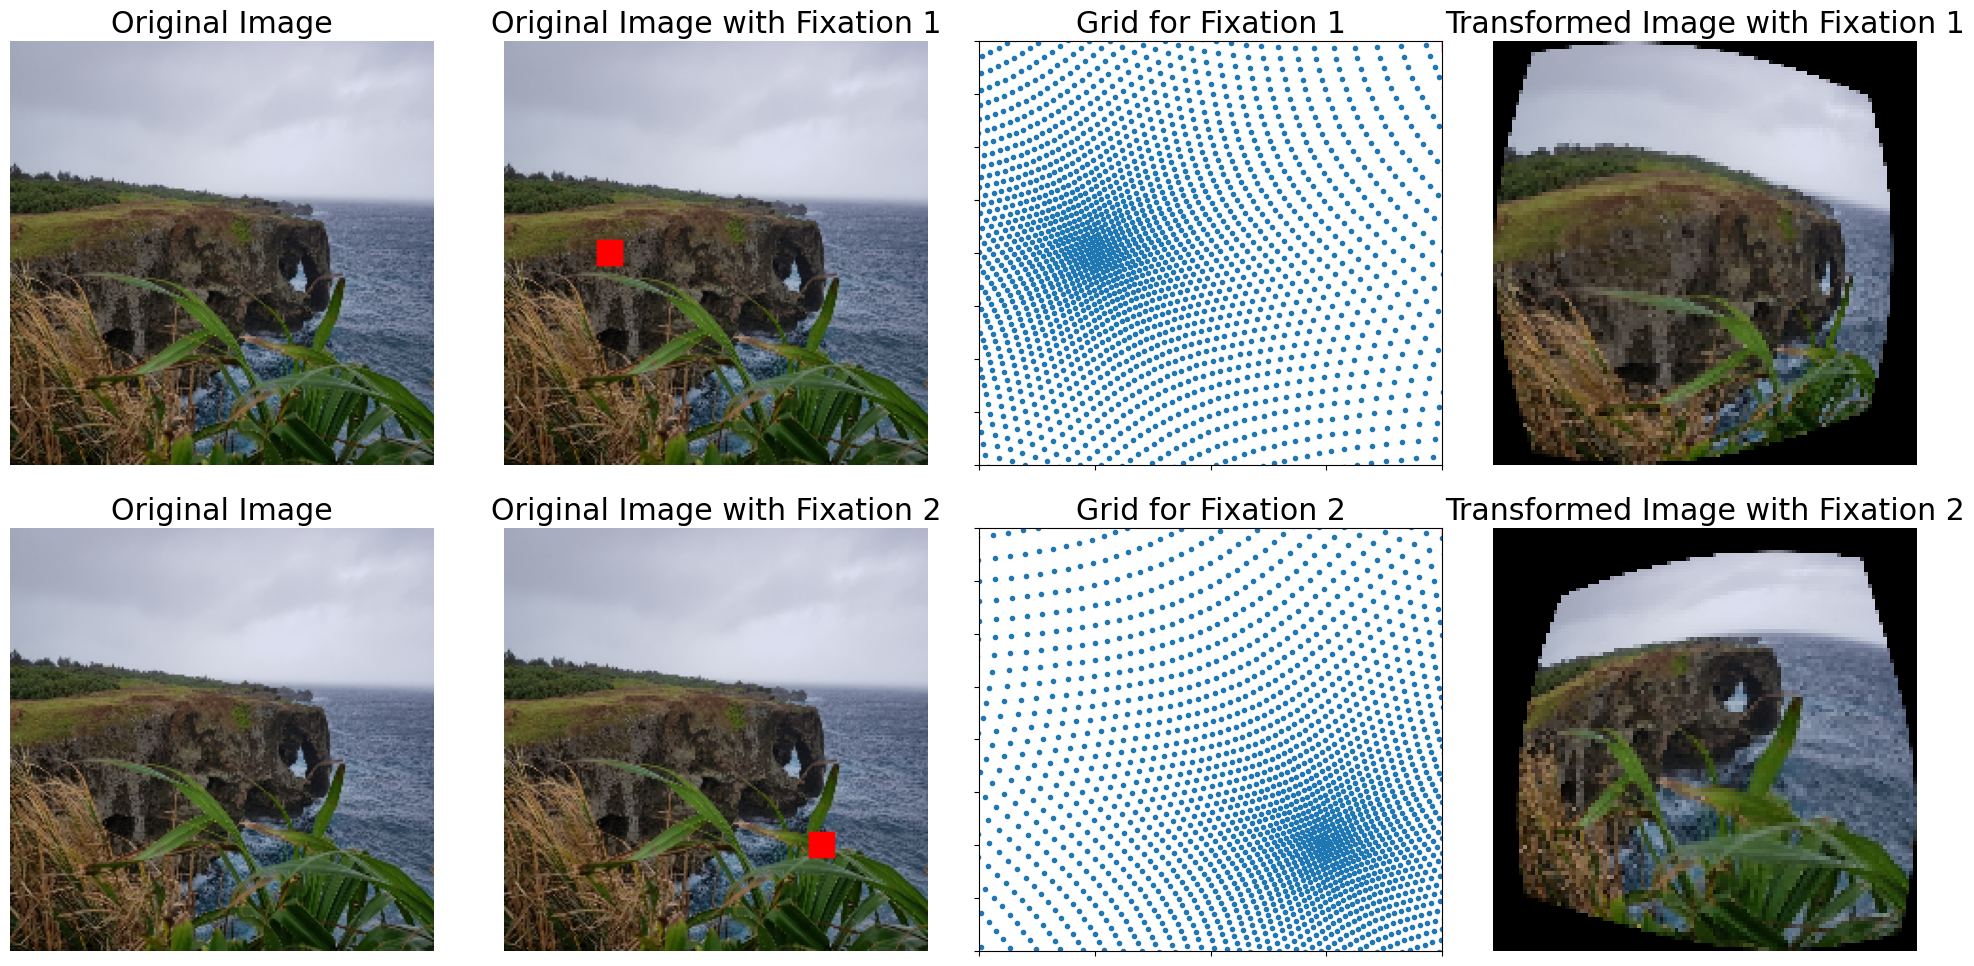

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams.update({'font.size': 18})  # You can change '14' to your desired font size


# Define function to convert Tensor to image and correct color channel order
def tensor_to_img(tensor):
    # Permute the tensor from (C, H, W) to (H, W, C) and convert to numpy
    image = tensor.detach().cpu().permute(1, 2, 0).numpy()
    # Convert from BGR to RGB
    return image[..., ::-1]

# Create a figure with subplots in 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns

# First row of subplots
# Plot Original Image 1
axs[0, 0].imshow(tensor_to_img(img_b[0]))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Plot Original Image 1 with Fixation
axs[0, 1].imshow(tensor_to_img(img_b_point[0]))
axs[0, 1].set_title('Original Image with Fixation 1')
axs[0, 1].axis('off')

# Plot Transformed Image 1
axs[0, 3].imshow(tensor_to_img(actmap_warp2[0]))
axs[0, 3].set_title('Transformed Image with Fixation 1')
axs[0, 3].axis('off')

# Plot grid for first fixation
grid_lin = grid_forward[0].cpu().view(-1, 2)
axs[0, 2].plot(grid_lin[::5, 0], grid_lin[::5, 1], '.')
red_box = Rectangle((1, -1), width=0.05, height=0.05, linewidth=1, edgecolor='r', facecolor='none')
axs[0, 2].add_patch(red_box)
axs[0, 2].set_xlim(-1., 1.)
axs[0, 2].set_ylim(-1., 1.)
axs[0, 2].invert_yaxis()  # Flip the y-axis
axs[0, 2].set_xticklabels([])  # Remove x tick labels
axs[0, 2].set_yticklabels([])  # Remove y tick labels
axs[0, 2].set_title('Grid for Fixation 1')

# Second row of subplots
# Plot Original Image 2
axs[1, 0].imshow(tensor_to_img(img_b[1]))
axs[1, 0].set_title('Original Image')
axs[1, 0].axis('off')

# Plot Original Image 2 with Fixation
axs[1, 1].imshow(tensor_to_img(img_b_point[1]))
axs[1, 1].set_title('Original Image with Fixation 2')
axs[1, 1].axis('off')

# Plot Transformed Image 2
axs[1, 3].imshow(tensor_to_img(actmap_warp2[1]))
axs[1, 3].set_title('Transformed Image with Fixation 2')
axs[1, 3].axis('off')

# Plot grid for second fixation
grid_lin = grid_forward[1].cpu().view(-1, 2)
axs[1, 2].plot(grid_lin[::5, 0], grid_lin[::5, 1], '.')
red_box = Rectangle((1, -1), width=0.05, height=0.05, linewidth=1, edgecolor='r', facecolor='none')
axs[1, 2].add_patch(red_box)
axs[1, 2].set_xlim(-1., 1.)
axs[1, 2].set_ylim(-1., 1.)
axs[1, 2].invert_yaxis()  # Flip the y-axis
axs[1, 2].set_xticklabels([])  # Remove x tick labels
axs[1, 2].set_yticklabels([])  # Remove y tick labels
axs[1, 2].set_title('Grid for Fixation 2')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
